In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
from sklearn import neighbors, preprocessing

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# get jobs

# loop over SF timesteps

# run isoconfig runs and collect dynamic information
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [2]:
for job in project.find_jobs({"delta": 0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0
    path = sorted(glob.glob(job.fn("short_runs/temp-*/")))[0]
    temp = float(utils.extract_between(path, "temp-", "/"))
    path = pathlib.Path(path)

In [3]:
temp

0.45

In [161]:
struct_df = pd.read_parquet((path / "sfs.parquet").as_posix())
print(len(struct_df))
struct_df = struct_df[(struct_df["frame"] == 0)]
print(len(struct_df))
struct_df.head()

294912
32768


,frame,tag,type,phop,sf
0,0,0,0,0.000713,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01931316, 0.0, 0.2..."
1,0,1,0,0.000862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.014731606, 0.0, 0...."
2,0,2,0,0.014712,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.016687617, 0.0, 0...."
3,0,3,0,0.000485,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.02962939, 0.002191..."
4,0,4,0,0.001081,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129..."


In [162]:
descr_df = pd.read_parquet((path / "struct-descr.parquet").as_posix())
print(len(descr_df))
descr_df = descr_df[(descr_df["frame"] == 0) & (descr_df["type"] == 0)]
print(len(descr_df))
descr_df.head()

235935
26215


,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang
0,0,0,0,0.000713,0.118890,-2.236004,-3.457283,-2.535503,False
1,0,1,0,0.000862,-0.385413,-2.102081,-2.999533,-2.505927,False
2,0,2,0,0.014712,-0.009888,-2.508852,-4.182886,-2.655738,False
3,0,3,0,0.000485,-0.710552,-2.242270,-3.260788,-2.456938,False
4,0,4,0,0.001081,-0.273929,-3.410165,-6.389401,-3.671592,False


In [163]:
len(struct_df), len(descr_df)

(32768, 26215)

In [164]:
traj = gsd.hoomd.open(path / "traj.gsd")
snap = traj[0]

In [165]:
struct_df.head()

,frame,tag,type,phop,sf
0,0,0,0,0.000713,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01931316, 0.0, 0.2..."
1,0,1,0,0.000862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.014731606, 0.0, 0...."
2,0,2,0,0.014712,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.016687617, 0.0, 0...."
3,0,3,0,0.000485,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.02962939, 0.002191..."
4,0,4,0,0.001081,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129..."


In [166]:
orig_sfs = list(np.stack(struct_df[struct_df["type"] == 0]["sf"].to_numpy()))

In [167]:
len(orig_sfs),len(struct_df["sf"])

(26215, 32768)

In [168]:
scaler = preprocessing.StandardScaler().fit(orig_sfs)

sfs = scaler.transform(orig_sfs)

In [234]:
def digitize_mask(x, mu_min, mu_max, bins):
    digs = np.floor((x - mu_min) / (mu_max - mu_min) * bins).astype(np.int32)
    return np.ma.masked_array(digs, mask=(digs < 0) | (digs >= bins))


def digitize_in_bounds(x, mu_min, mu_max, bins):
    digs = digitize_mask(x, mu_min, mu_max, bins)
    return digs[~digs.mask].data


def bin_linspaced_data(x, mu_min, mu_max, bins):
    digs = digitize_in_bounds(x, mu_min, mu_max, bins)
    return np.bincount(digs, minlength=bins)


def pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi):
    dr = r[1] - r[0]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return -2.0*np.pi*phi*f_a*np.sum(np.nan_to_num(g_a*np.log(g_a) - g_a + 1)*r*r)*dr \
                + -2.0*np.pi*phi*f_b*np.sum(np.nan_to_num(g_b*np.log(g_b) - g_b + 1)*r*r)*dr

r_be = np.linspace(0.1, 3.0, 60)
r_bc = r_be[:-1] + np.diff(r_be)/2

def _default_array():
    return np.zeros_like(r_bc)


def compute_ball_tree_entropy(df, nbrs, snap, f_a=0.8, f_b=0.2, phi=1.2):

    vol = 4/3*np.pi*r_be[-1]**3
    shells = 4*np.pi*r_bc**2*(r_be[1] - r_be[0])

    all_distances, all_indices = nbrs.kneighbors(sfs[:1000])

    box = freud.box.Box.from_box(snap.configuration.box)
    pos = snap.particles.position
    pos_a = pos[snap.particles.typeid == 0]
    pos_b = pos[snap.particles.typeid == 1]
    nlist_query_a = freud.locality.AABBQuery.from_system((box, pos_a))
    nlist_query_b = freud.locality.AABBQuery.from_system((box, pos_b))

    output = []

    nlist_a = nlist_query_a.query(pos, dict(r_max=3.0, r_min=0.1)).toNeighborList()
    nlist_b = nlist_query_b.query(pos, dict(r_max=3.0, r_min=0.1)).toNeighborList()

    rdfs = []

    for idx in range(len(pos)):
        # if idx%1000 == 0:
        #     print(idx)
        s = nlist_a.segments[idx]
        nc = nlist_a.neighbor_counts[idx]
        dists = nlist_a.distances[s:s+nc]
        rdf_a = bin_linspaced_data(dists, r_be[0], r_be[-1], len(r_be)-1)
        s = nlist_b.segments[idx]
        nc = nlist_b.neighbor_counts[idx]
        dists = nlist_b.distances[s:s+nc]
        rdf_b = bin_linspaced_data(dists, r_be[0], r_be[-1], len(r_be)-1)\
        
        rdfs.append([rdf_a, rdf_b])
        
    rdfs = np.array(rdfs)

    print(len(rdfs))

    for idx, (distances, indices) in enumerate(zip(all_distances, all_indices)):
        # if idx%100 == 0:
        #     print(idx)

        # print(indices)

        ids = df.iloc[indices]["tag"].to_numpy()

        rdf_a = np.sum(rdfs[ids][:,0], axis=0)
        rdf_b = np.sum(rdfs[ids][:,1], axis=0)
        # plt.plot(rdf_a)
        # plt.plot(rdf_b)
        
        g_a = rdf_a/shells/np.sum(rdf_a)*vol
        g_b = rdf_b/shells/np.sum(rdf_b)*vol
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r_bc, phi)
        output.append(s)

    return np.array(output)

def compute_ball_tree_rdfs(df, nbrs, snap, f_a=0.8, f_b=0.2, phi=1.2):

    vol = 4/3*np.pi*r_be[-1]**3
    shells = 4*np.pi*r_bc**2*(r_be[1] - r_be[0])

    all_distances, all_indices = nbrs.kneighbors(sfs[:1000])

    box = freud.box.Box.from_box(snap.configuration.box)
    pos = snap.particles.position
    pos_a = pos[snap.particles.typeid == 0]
    pos_b = pos[snap.particles.typeid == 1]
    nlist_query_a = freud.locality.AABBQuery.from_system((box, pos_a))
    nlist_query_b = freud.locality.AABBQuery.from_system((box, pos_b))

    output = []

    nlist_a = nlist_query_a.query(pos, dict(r_max=3.0, r_min=0.1)).toNeighborList()
    nlist_b = nlist_query_b.query(pos, dict(r_max=3.0, r_min=0.1)).toNeighborList()

    rdfs = []

    for idx in range(len(pos)):
        # if idx%1000 == 0:
        #     print(idx)
        s = nlist_a.segments[idx]
        nc = nlist_a.neighbor_counts[idx]
        dists = nlist_a.distances[s:s+nc]
        rdf_a = bin_linspaced_data(dists, r_be[0], r_be[-1], len(r_be)-1)
        s = nlist_b.segments[idx]
        nc = nlist_b.neighbor_counts[idx]
        dists = nlist_b.distances[s:s+nc]
        rdf_b = bin_linspaced_data(dists, r_be[0], r_be[-1], len(r_be)-1)\
        
        rdfs.append([rdf_a, rdf_b])
        
    rdfs = np.array(rdfs)

    print(len(rdfs))

    for idx, (distances, indices) in enumerate(zip(all_distances, all_indices)):
        # if idx%100 == 0:
        #     print(idx)

        # print(indices)

        ids = df.iloc[indices]["tag"].to_numpy()

        rdf_a = np.sum(rdfs[ids][:,0], axis=0)
        rdf_b = np.sum(rdfs[ids][:,1], axis=0)
        # plt.plot(rdf_a)
        # plt.plot(rdf_b)
        
        g_a = rdf_a/shells/np.sum(rdf_a)*vol
        g_b = rdf_b/shells/np.sum(rdf_b)*vol
        
        output.append([g_a, g_b])

    return np.array(output)

In [235]:
nbrs = neighbors.NearestNeighbors(n_neighbors=200, algorithm='ball_tree').fit(sfs)

In [236]:
ball_tree_rdfs = compute_ball_tree_rdfs(struct_df, nbrs, snap)

32768


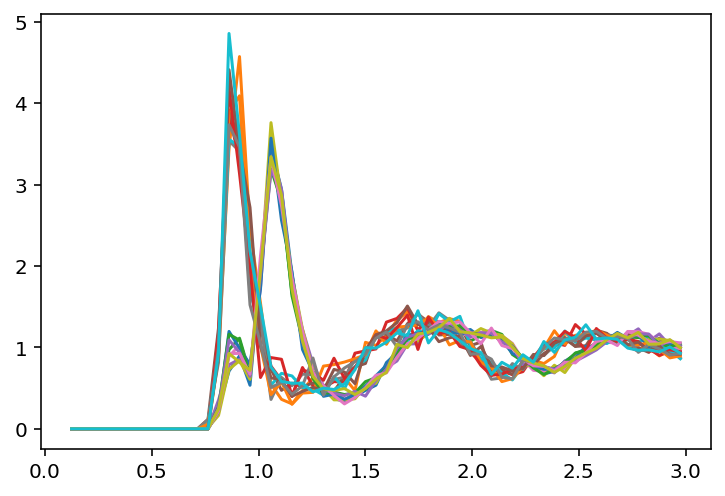

In [238]:
for i in range(10):
    plt.plot(r_bc, ball_tree_rdfs[i].T);

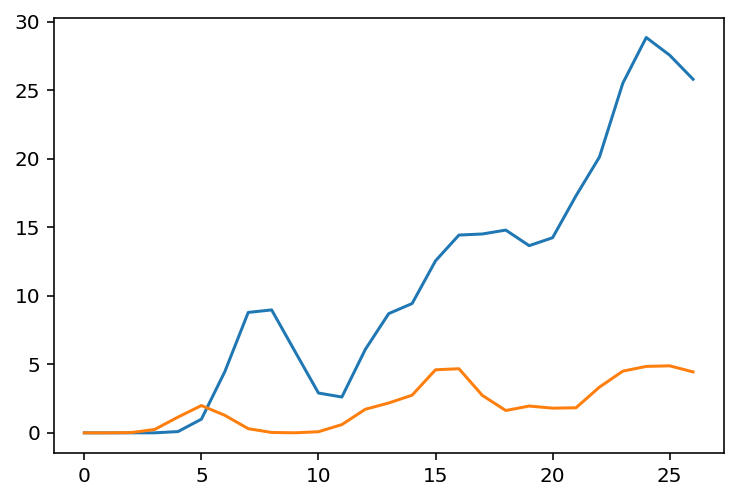

In [206]:
plt.plot(orig_sfs[0][::2]);
plt.plot(orig_sfs[0][1::2]);

In [171]:
entropies = compute_ball_tree_entropy(struct_df, nbrs, snap)

0
100
200
300
400
500
600
700
800
900


(array([ 3.,  2.,  5.,  7.,  1.,  5.,  9., 10.,  9., 10., 14., 20., 25.,
        26., 17., 21., 28., 22., 33., 37., 36., 38., 34., 49., 40., 38.,
        39., 52., 50., 32., 36., 38., 43., 31., 27., 25., 21., 23., 12.,
         7.,  6.,  6.,  5.,  2.,  3.,  2.,  0.,  0.,  0.,  1.]),
 array([-5.06790651, -5.00014674, -4.93238698, -4.86462721, -4.79686744,
        -4.72910767, -4.6613479 , -4.59358814, -4.52582837, -4.4580686 ,
        -4.39030883, -4.32254907, -4.2547893 , -4.18702953, -4.11926976,
        -4.05150999, -3.98375023, -3.91599046, -3.84823069, -3.78047092,
        -3.71271116, -3.64495139, -3.57719162, -3.50943185, -3.44167208,
        -3.37391232, -3.30615255, -3.23839278, -3.17063301, -3.10287324,
        -3.03511348, -2.96735371, -2.89959394, -2.83183417, -2.76407441,
        -2.69631464, -2.62855487, -2.5607951 , -2.49303533, -2.42527557,
        -2.3575158 , -2.28975603, -2.22199626, -2.1542365 , -2.08647673,
        -2.01871696, -1.95095719, -1.88319742, -1.81543766,

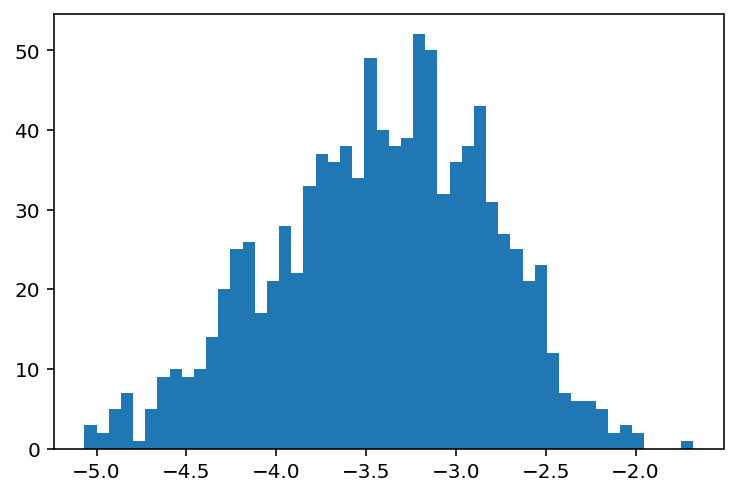

In [172]:
plt.hist(entropies, bins=50)

In [173]:
tmp["ball-entropy"] = entropies
tmp.corr()

/tmp/ipykernel_130669/2400366608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["ball-entropy"] = entropies


,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang,ball-entropy
frame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tag,NaN,1.000000,NaN,-0.000981,-0.056121,-0.051409,-0.030320,-0.013995,NaN,0.013958
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phop,NaN,-0.000981,NaN,1.000000,0.269541,0.102799,0.119378,0.157575,NaN,-0.023991
softness,NaN,-0.056121,NaN,0.269541,1.000000,0.343610,0.347960,0.458015,NaN,0.021440
entropy,NaN,-0.051409,NaN,0.102799,0.343610,1.000000,0.721154,0.597931,NaN,0.072071
entropy-binary,NaN,-0.030320,NaN,0.119378,0.347960,0.721154,1.000000,0.865998,NaN,0.045976
entropy-binary-opt,NaN,-0.013995,NaN,0.157575,0.458015,0.597931,0.865998,1.000000,NaN,0.016020
rearrang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ball-entropy,NaN,0.013958,NaN,-0.023991,0.021440,0.072071,0.045976,0.016020,NaN,1.000000


In [175]:
len(tmp)

1000

In [174]:
descr_df.corr()

,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang
frame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tag,NaN,1.000000,NaN,0.011839,-0.001160,-0.003964,0.002814,0.001317,-0.006947
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phop,NaN,0.011839,NaN,1.000000,0.211229,0.092783,0.095601,0.122364,0.551684
softness,NaN,-0.001160,NaN,0.211229,1.000000,0.327106,0.343748,0.452416,0.028178
entropy,NaN,-0.003964,NaN,0.092783,0.327106,1.000000,0.702028,0.567970,0.018127
entropy-binary,NaN,0.002814,NaN,0.095601,0.343748,0.702028,1.000000,0.864967,0.018501
entropy-binary-opt,NaN,0.001317,NaN,0.122364,0.452416,0.567970,0.864967,1.000000,0.019032
rearrang,NaN,-0.006947,NaN,0.551684,0.028178,0.018127,0.018501,0.019032,1.000000


In [176]:

entropies = compute_ball_tree_entropy(struct_df, nbrs, snap)
tmp = descr_df[:1000]


0
100
200
300
400
500
600
700
800
900


In [179]:
tmp["ball-entropy"] = entropies
tmp.corr()

/tmp/ipykernel_130669/2400366608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["ball-entropy"] = entropies


,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang,ball-entropy
frame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tag,NaN,1.000000,NaN,-0.000981,-0.056121,-0.051409,-0.030320,-0.013995,NaN,0.013958
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phop,NaN,-0.000981,NaN,1.000000,0.269541,0.102799,0.119378,0.157575,NaN,-0.023991
softness,NaN,-0.056121,NaN,0.269541,1.000000,0.343610,0.347960,0.458015,NaN,0.021440
entropy,NaN,-0.051409,NaN,0.102799,0.343610,1.000000,0.721154,0.597931,NaN,0.072071
entropy-binary,NaN,-0.030320,NaN,0.119378,0.347960,0.721154,1.000000,0.865998,NaN,0.045976
entropy-binary-opt,NaN,-0.013995,NaN,0.157575,0.458015,0.597931,0.865998,1.000000,NaN,0.016020
rearrang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ball-entropy,NaN,0.013958,NaN,-0.023991,0.021440,0.072071,0.045976,0.016020,NaN,1.000000
